In [2]:
import os
import math
import numpy as np
import random
import logging

# Bring in PyTorch
import torch
import torch.nn as nn

# Most of the examples have typing on the signatures for readability
from typing import Optional, Callable, List, Tuple
from copy import deepcopy
# For data loading
from torch.utils.data import Dataset, IterableDataset, TensorDataset, DataLoader
import json
import glob
import gzip
import bz2
#import wandb

from sklearn.metrics import precision_recall_fscore_support
from scipy.spatial.distance import cosine

import pandas as pd

import matplotlib.pyplot as plt

# For progress and timing
from tqdm.auto import tqdm, trange
import time

# check if gpu is available
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
print(f"Using '{device}' device")

Using 'cuda' device


In [3]:
class BertPositionalEmbedding(nn.Module):
    def __init__(self, vocab_dim: int, 
                 hidden_dim: int = 768, 
                 padding_idx: int = 0, 
                 max_seq_length: int = 512):

        super().__init__()

        '''
        Initialize the Embedding Layers
        '''

        self.word_embeddings = nn.Embedding(vocab_dim, hidden_dim, padding_idx=padding_idx)
        self.pos_embeddings = nn.Embedding(max_seq_length, hidden_dim)

        self.padding_idx = padding_idx

    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:

        '''
        Define the forward pass of the Embedding Layers
        '''

        token_embeddings = self.word_embeddings(token_ids)

        pos_ids = torch.arange(0, token_ids.size(-1), dtype=torch.long, device=token_ids.device)
        pos_embeddings = self.pos_embeddings(pos_ids)

        return token_embeddings + pos_embeddings

class MultiHeadedAttention(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int):
        '''
        Arguments:
        hidden_size: The total size of the hidden layer (across all heads)
        num_heads: The number of attention heads to use
        '''
        super().__init__()

        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        '''
        Initialize the Multi-Headed Attention Layer
        '''

        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)

        self.output_proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor] = None):
        '''
        Arguments:
        query: The input embeddings for the query
        key: The input embeddings for the key
        value: The input embeddings for the value
        mask: A boolean mask of which tokens are valid to use for computing attention (see collate below)
        '''
        batch_size = query.shape[0]

        queries = query.view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        keys = key.view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        values = value.view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.head_size)

        attention_weights = torch.softmax(attention_scores, dim=-1)
        weighted_values = torch.matmul(attention_weights, values)

        weighted_values = weighted_values.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.head_size)
        output = self.output_proj(weighted_values)

        return output, attention_weights

def feed_forward_layer(
    hidden_size: int,
    feed_forward_size: Optional[int] = None,
    activation: nn.Module = nn.GELU()
):
    '''
    Arguments:
      - hidden_size: The size of the input and output of the feed forward layer.
      - feed_forward_size: The size of the hidden layer in the feed forward network. If None, defaults to 4 * hidden_size. This size
        specifies the size of the middle layer in the feed forward network.
      - activation: The activation function to use in the feed forward network

    Returns:
        A PyTorch module representing the feed forward layer.
    '''

    if feed_forward_size is None:
        feed_forward_size = hidden_size * 4

    feed_forward = nn.Sequential(
        nn.Linear(hidden_size, feed_forward_size),
        activation,
        nn.Linear(feed_forward_size, hidden_size)
    )

    return feed_forward

class TransformerEncoderLayer(nn.Module):

    def __init__(
        self,
        hidden_size: int = 256,
        num_heads: int = 8,
        dropout: float = 0.1,
        activation: nn.Module = nn.ReLU(),
        feed_forward_size: Optional[int] = None,
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.feed_forward_size = feed_forward_size or 4 * hidden_size

        self.attention = MultiHeadedAttention(hidden_size, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, self.feed_forward_size),
            activation,
            nn.Linear(self.feed_forward_size, hidden_size)
        )

    def maybe_dropout(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        '''
        Returns the output of the transformer encoder layer and the attention weights from the self-attention layer
        '''
        attention_output, attention_weights = self.attention(x, x, x, mask)
        attention_output = self.maybe_dropout(attention_output)

        residual_output = attention_output + x  

        feed_forward_output = self.feed_forward(residual_output)
        feed_forward_output = self.maybe_dropout(feed_forward_output)

        output = feed_forward_output + residual_output  

        return output, attention_weights

class MLMHead(nn.Module):
    def __init__(self, word_embeddings: nn.Embedding):
        '''
        Arguments:
            word_embeddings: The word embeddings to use for the prediction
        '''

        super().__init__()
        self.word_embeddings = word_embeddings

    def forward(self, x):
        '''
        x: The input tensor to the MLM head containing a batch of sequences of
           contextualized word embeddings (activations from the transformer encoder 
           layers)
        '''
        return x @ self.word_embeddings.weight.transpose(0, 1)

class Pooler(nn.Module):
    def __init__(self, hidden_size: int = 768):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        cls_embeddings = x[:, 0, :]  

        pooled_output = self.dense(cls_embeddings)
        pooled_output = self.activation(pooled_output)

        return pooled_output

class BERT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        padding_idx: int = 0,
        hidden_size: int = 768,
        num_heads: int = 12,
        num_layers: int = 12,
        dropout: float = 0.1,
        activation: nn.Module = nn.GELU(),
        feed_forward_size: Optional[int] = None,
        mode: str = "mlm",
        num_classes: Optional[int] = None,
    ):
        '''
        Defines BERT model architecture. Note that the arguments are the same as the default
        BERT model in HuggingFace but we'll be training a *much* smaller model for this homework.

        Arguments:
        vocab_size: The size of the vocabulary (determined by the tokenizer)
        padding_idx: The index of the padding token in the vocabulary (defined by the tokenizer)
        hidden_size: The size of the hidden layer and embeddings in the transformer encoder
        num_heads: The number of attention heads to use in the transformer encoder
        num_layers: The number of layers to use in the transformer encoder (each layer is a TransformerEncoderLayer)
        dropout: The dropout rate to use in the transformer encoder (what % of times to randomly zero out activations)
        activation: The activation function to use in the transformer encoder
        feed_forward_size: The size of the hidden layer in the feed forward network in the transformer encoder. If None, defaults to 4 * hidden_size
        mode: The mode of the BERT model. Either "mlm" for masked language modeling or "classification" for sequence classification
        num_classes: The number of classes to use in the classification layer.
        '''

        super().__init__()

        self.mode = mode
        self.hidden_size = hidden_size

        self.embeddings = BertPositionalEmbedding(vocab_size, hidden_size, padding_idx)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, dropout, activation, feed_forward_size)
            for _ in range(num_layers)
        ])
        self.mlm_head = MLMHead(self.embeddings.word_embeddings)
        self.pooler = Pooler(hidden_size)

        if mode == "classification":
            self.classifier = nn.Linear(hidden_size, num_classes)
        else:
            self.classifier = None

        self.apply(self.init_layer_weights)

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        '''
        arguments:
        x: The input token ids
        mask: The attention mask to apply to the input (see the collate function below)
        '''
        embeddings = self.embeddings(x)

        attention_weights = []
        for layer in self.encoder_layers:
            embeddings, attention_weight = layer(embeddings, mask)
            attention_weights.append(attention_weight)

        if self.mode == "mlm":
            output = self.mlm_head(embeddings)
        else:
            pooled_output = self.pooler(embeddings)
            output = self.classifier(pooled_output)

        return output, attention_weights

    def init_layer_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=True)

In [4]:
model_path = "bert_model_large_e8.pt"
bert = BERT(vocab_size=tokenizer.get_vocab_size(), 
                  hidden_size=768, 
                  num_heads=12, 
                  num_layers=6,
                  mode="mlm").to(device)


bert = torch.load(model_path)
bert.to(device)


BERT(
  (embeddings): BertPositionalEmbedding(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (pos_embeddings): Embedding(512, 768)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (dropout): Dropout(p=0.1, inplace=False)
      (attention): MultiHeadedAttention(
        (query_proj): Linear(in_features=768, out_features=768, bias=True)
        (key_proj): Linear(in_features=768, out_features=768, bias=True)
        (value_proj): Linear(in_features=768, out_features=768, bias=True)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (mlm_head): MLMHead(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
  )
  (pooler): Pooler(
    (dense): Linear(in_features=768, out_features

In [5]:
bert.eval() 
word_embeds = bert.embeddings.word_embeddings

In [6]:
def get_neighbors(embeddings, tokenizer, target_word, num_neighbors=10):
    """ 
    Finds the top k most similar words to a target word
    """
    outputs = []
    target_word_id = tokenizer.token_to_id(target_word)
    target_word_id_tensor = torch.LongTensor([target_word_id]).to(embeddings.weight.device)  # Use the device of the embedding matrix
    target_embedding = embeddings(target_word_id_tensor)
    similarities = torch.cosine_similarity(target_embedding, embeddings.weight)

    for word_id, similarity in enumerate(similarities):
        other_word = tokenizer.id_to_token(word_id)
        result = {"word": other_word, "score": similarity.item()}
        outputs.append(result)

    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:num_neighbors+1]


In [11]:
print(get_neighbors(word_embeds, tokenizer, "school", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "pen", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "library", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "novel", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "chapter", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "author", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "plot", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "character", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "fiction", num_neighbors=20))
print(get_neighbors(word_embeds, tokenizer, "nonfiction", num_neighbors=20))

[{'word': 'college', 'score': 0.47620171308517456}, {'word': 'grade', 'score': 0.3931868374347687}, {'word': 'town', 'score': 0.39206624031066895}, {'word': 'illness', 'score': 0.39198777079582214}, {'word': 'england', 'score': 0.3867168128490448}, {'word': 'classes', 'score': 0.38038408756256104}, {'word': 'law', 'score': 0.37883609533309937}, {'word': 'english', 'score': 0.3765135407447815}, {'word': 'class', 'score': 0.37614905834198}, {'word': 'younger', 'score': 0.37568819522857666}, {'word': 'graduate', 'score': 0.3754894733428955}, {'word': 'bookstore', 'score': 0.37439286708831787}, {'word': 'level', 'score': 0.37346774339675903}, {'word': 'church', 'score': 0.3724204897880554}, {'word': '##ern', 'score': 0.3715120255947113}, {'word': '##und', 'score': 0.3710486590862274}, {'word': 'east', 'score': 0.37096235156059265}, {'word': '##ler', 'score': 0.37068939208984375}, {'word': '##rah', 'score': 0.3706338405609131}, {'word': 'grandchildren', 'score': 0.36929500102996826}]
[{'wor

In [12]:

def complete(text, sampling, tokenizer, model, device=device):
    '''
    Given a sentence with one or more masked tokens, each written as [MASK], complete the sentence using the BERT model.
    If sampling is True, the model will sample from the distribution of possible tokens for each masked token.
    
    Args:
        text (str): The sentence with masked tokens.
        sampling (bool): Whether to sample from the distribution of possible tokens for each masked token. If False, returns the most likely token.
        tokenizer: The tokenizer for the BERT model.
        model: The BERT model.
        device (str): The device to use for computation ('cpu' or 'cuda').

    Returns:
        str: The completed sentence.
    '''
    with torch.no_grad():
        tokenized_input = tokenizer.encode(text)
        masked_offsets = [i for i, t in enumerate(tokenized_input.tokens) if t == '[MASK]']
        tokens = tokenized_input.tokens
        ids = torch.tensor(tokenized_input.ids, device=device).unsqueeze(0)
        response, attns = model(ids.to(device))
        response = response.squeeze(0)
        if sampling:
            sample_dist = torch.softmax(response, -1)
            output = torch.multinomial(sample_dist, num_samples=1)
            response = output.squeeze().tolist()
        else:
            response = response.argmax(-1).tolist()
        for off in masked_offsets:
            tokens[off] = tokenizer.id_to_token(response[off])
        return ' '.join(tokens[1:-1]).replace(' ##', '')


In [13]:
ORIGINAL_SENTENCES = [
    "really well crafted book. I have enjoyed it once and will savor it again soon.",
    "I relish a love triangle and these books encapsulate it and then some! I relish the characters and can't wait for the next installment.",
    "really well executed book. I have devoured it once and will cherish it again soon.",
    "I cherish a love triangle and these books portray it and then some! I cherish the characters and cannot wait for the next volume.",
    "really well written book. I have perused it once and will revisit it again soon.",
    "I adore a love triangle and these books depict it and then some! I adore the characters and eagerly await for the next release."
]

SENTENCES = [
    'really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.',
    'I [MASK] a love triangle [MASK] these books have it and then some! I [MASK] the characters and [MASK] wait for the next [MASK].',
    'really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.',
    'I [MASK] a love triangle [MASK] these books [MASK] it and then some! I [MASK] the characters and [MASK] wait for the next [MASK].',
    'really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.',
    'I [MASK] a love triangle [MASK] these books [MASK] it and then some! I [MASK] the characters and [MASK] wait for the next [MASK].'
]



for original, query in zip(ORIGINAL_SENTENCES, SENTENCES):
    print("Original: ", original)    
    print("Query: ", query)
    print("-" * 10)
    print("Guess: ", complete(query, False, tokenizer, bert, device))
    print("=" * 10)
    print('\n')


Original:  really well crafted book. I have enjoyed it once and will savor it again soon.
Query:  really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.
----------
Guess:  really well written book . i have read it once and will read it again soon .


Original:  I relish a love triangle and these books encapsulate it and then some! I relish the characters and can't wait for the next installment.
Query:  I [MASK] a love triangle [MASK] these books have it and then some! I [MASK] the characters and [MASK] wait for the next [MASK].
----------
Guess:  i have a love triangle and these books have it and then some ! i found the characters and i wait for the next book .


Original:  really well executed book. I have devoured it once and will cherish it again soon.
Query:  really well [MASK] book. I have [MASK] it once and will [MASK] it again soon.
----------
Guess:  really well written book . i have read it once and will read it again soon .


Original:  I cherish a love

In [14]:
def get_word_probabilities(text, tokenizer, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Given a sentence with a single masked token, returns a list of tuples containing a token and its probability
    from the softmax, sorted by probability.
    
    Args:
        text (str): The sentence with a single masked token.
        tokenizer: The tokenizer for the BERT model.
        model: The BERT model.
        device (str): The device to use for computation ('cpu' or 'cuda').
        
    Returns:
        List of tuples: Each tuple contains a token and its probability, sorted by probability.
    """
    with torch.no_grad():
        tokenized_input = tokenizer.encode(text)
        masked_index = tokenized_input.tokens.index('[MASK]')
        ids = torch.tensor(tokenized_input.ids, device=device).unsqueeze(0)
        logits, _ = model(ids)
        masked_logits = logits[0, masked_index]
        masked_probs = torch.softmax(masked_logits, dim=-1)
        token_probs = [(tokenizer.id_to_token(i), prob.item()) for i, prob in enumerate(masked_probs)]
        sorted_token_probs = sorted(token_probs, key=lambda x: x[1], reverse=True)
        return sorted_token_probs


In [15]:
top_word_sentences = [
    "I really enjoyed [MASK] book.",
    "I really like the [MASK] of this book.",
    "When I was [MASK], I liked to read.",
    "I really [MASK] this book.",
    "I really like the [MASK] of this book.",
    "When I was young, I liked to [MASK]."
]


for sentence in top_word_sentences:
    print("Sentence: ", sentence)
    sorted_token_probs = get_word_probabilities(sentence, tokenizer, bert, device)
    sorted_token_probs = sorted_token_probs[:10]
    print("Top words: ", sorted_token_probs)
    print("=" * 10)
    print('\n')

Sentence:  I really enjoyed [MASK] book.
Top words:  [('this', 0.5602049827575684), ('the', 0.36519381403923035), ('first', 0.012437707744538784), ('a', 0.011785509064793587), ('every', 0.008014232851564884), ('his', 0.004379520192742348), ('her', 0.00393631448969245), ('each', 0.0037341099232435226), ('reading', 0.002705295104533434), ('it', 0.0012415663804858923)]


Sentence:  I really like the [MASK] of this book.
Top words:  [('description', 0.047308310866355896), ('reviews', 0.04473837465047836), ('rest', 0.03983403742313385), ('premise', 0.035020459443330765), ('beginning', 0.03465614095330238), ('content', 0.03134288266301155), ('first', 0.026263752952218056), ('style', 0.02490709163248539), ('point', 0.024284478276968002), ('quality', 0.024064214900135994)]


Sentence:  When I was [MASK], I liked to read.
Top words:  [('disappointed', 0.15102413296699524), ('reading', 0.09236764162778854), ('good', 0.025079265236854553), ('it', 0.020563269034028053), ('sorry', 0.019879663363099

Sentence 1: I enjoyed the novel and personalities since I could connect with it.


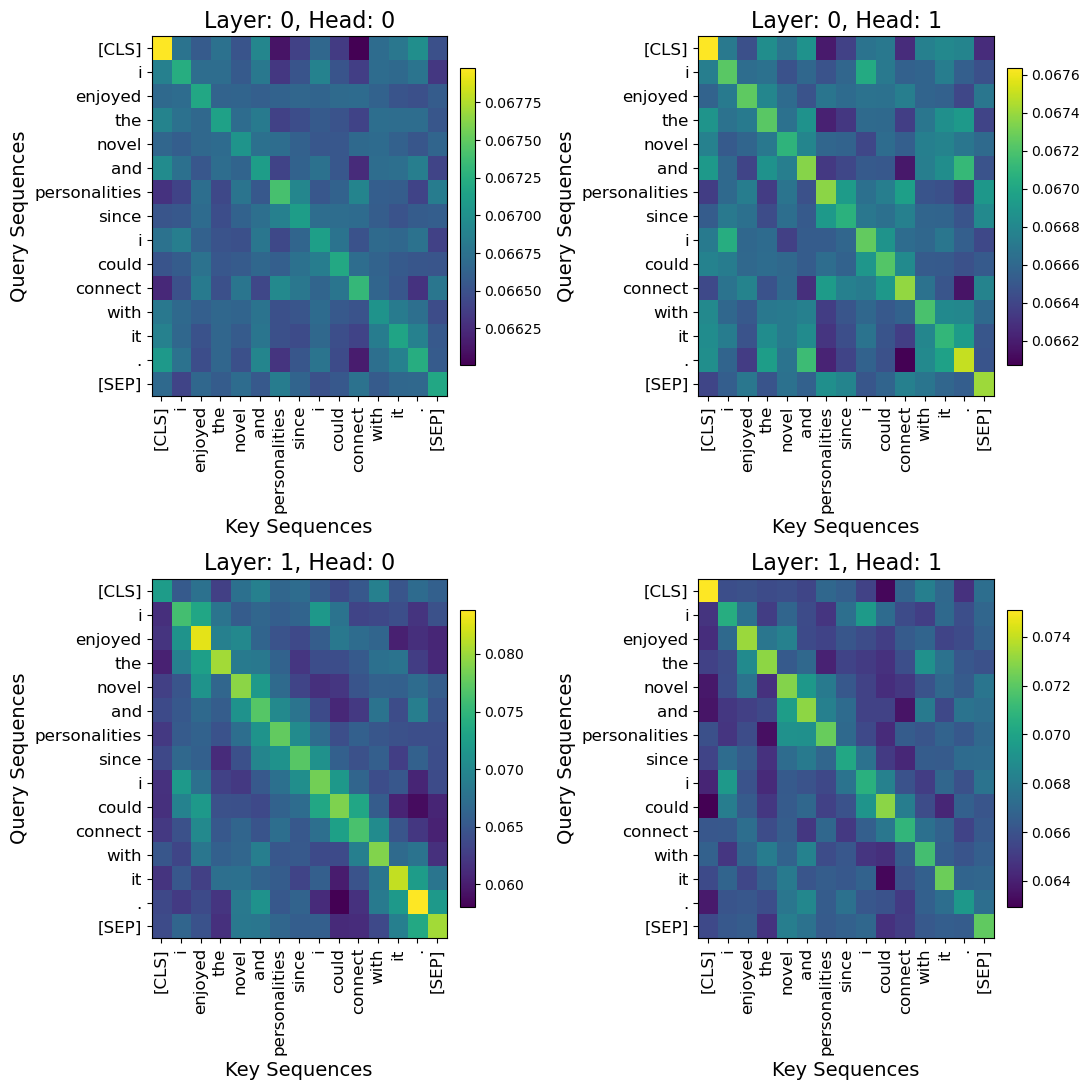

Sentence 2: I enjoyed the story and individuals as I found it relatable.


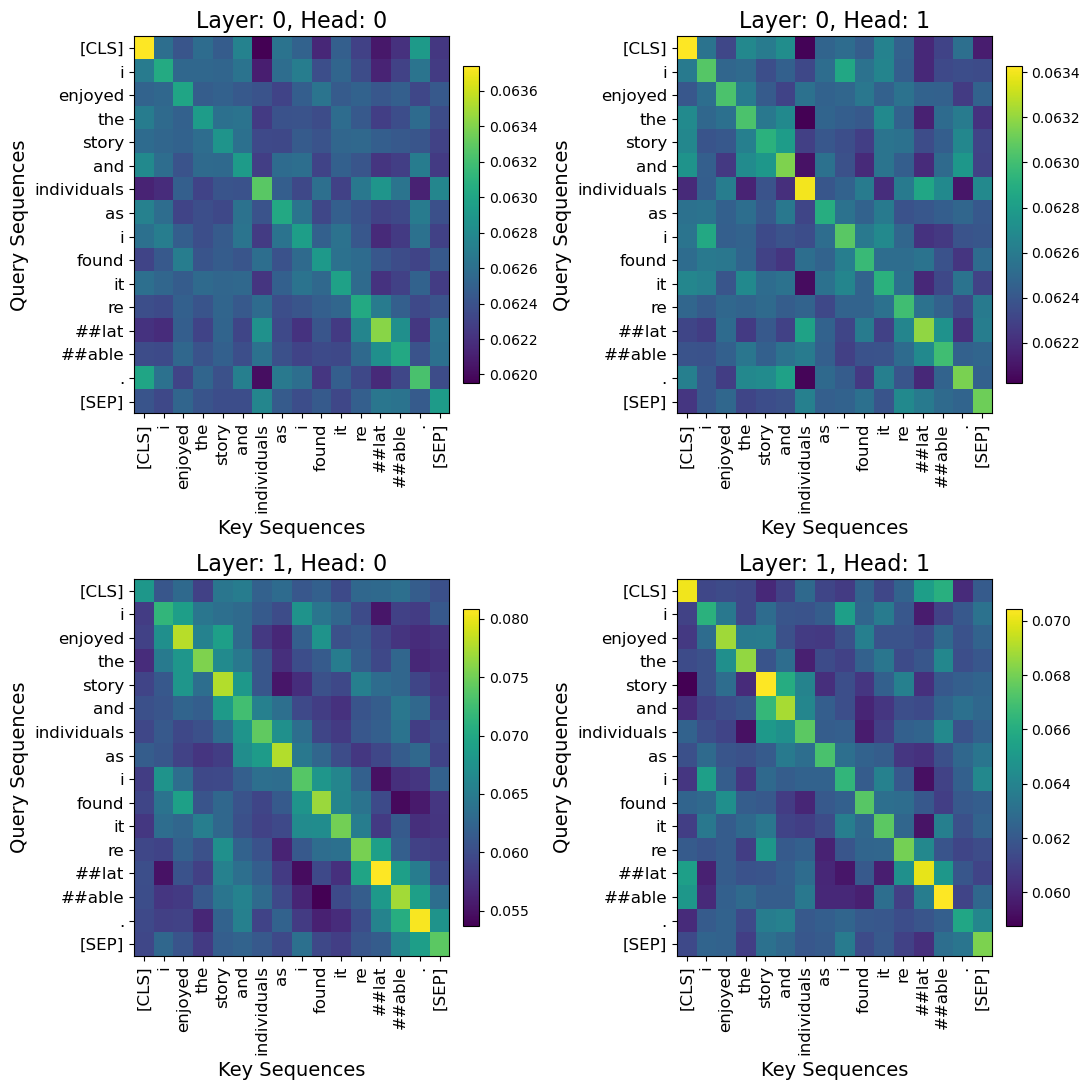

Sentence 3: I appreciated the book and its characters because I could identify with them.


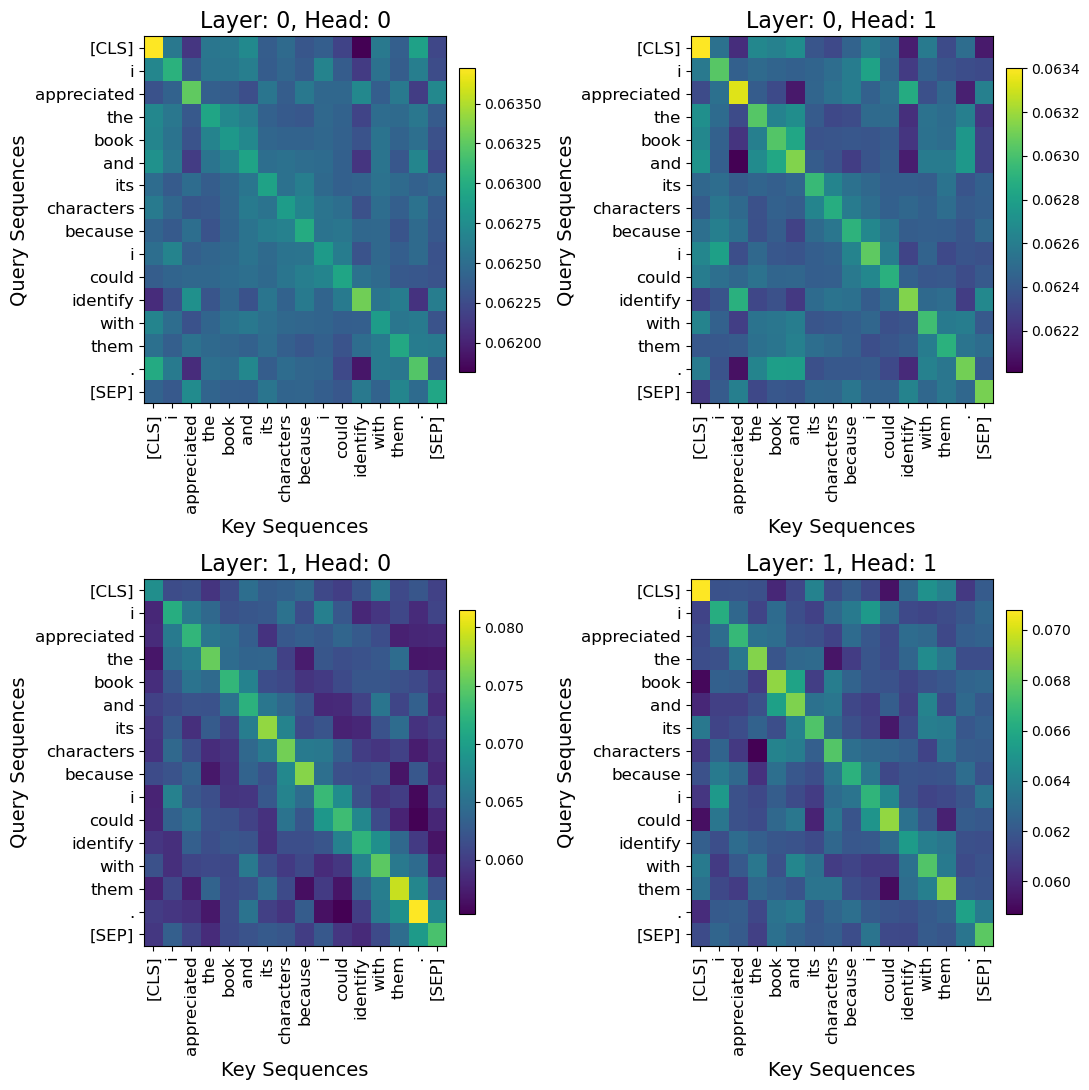

Sentence 4: I found the book and characters appealing due to the relatability I felt.


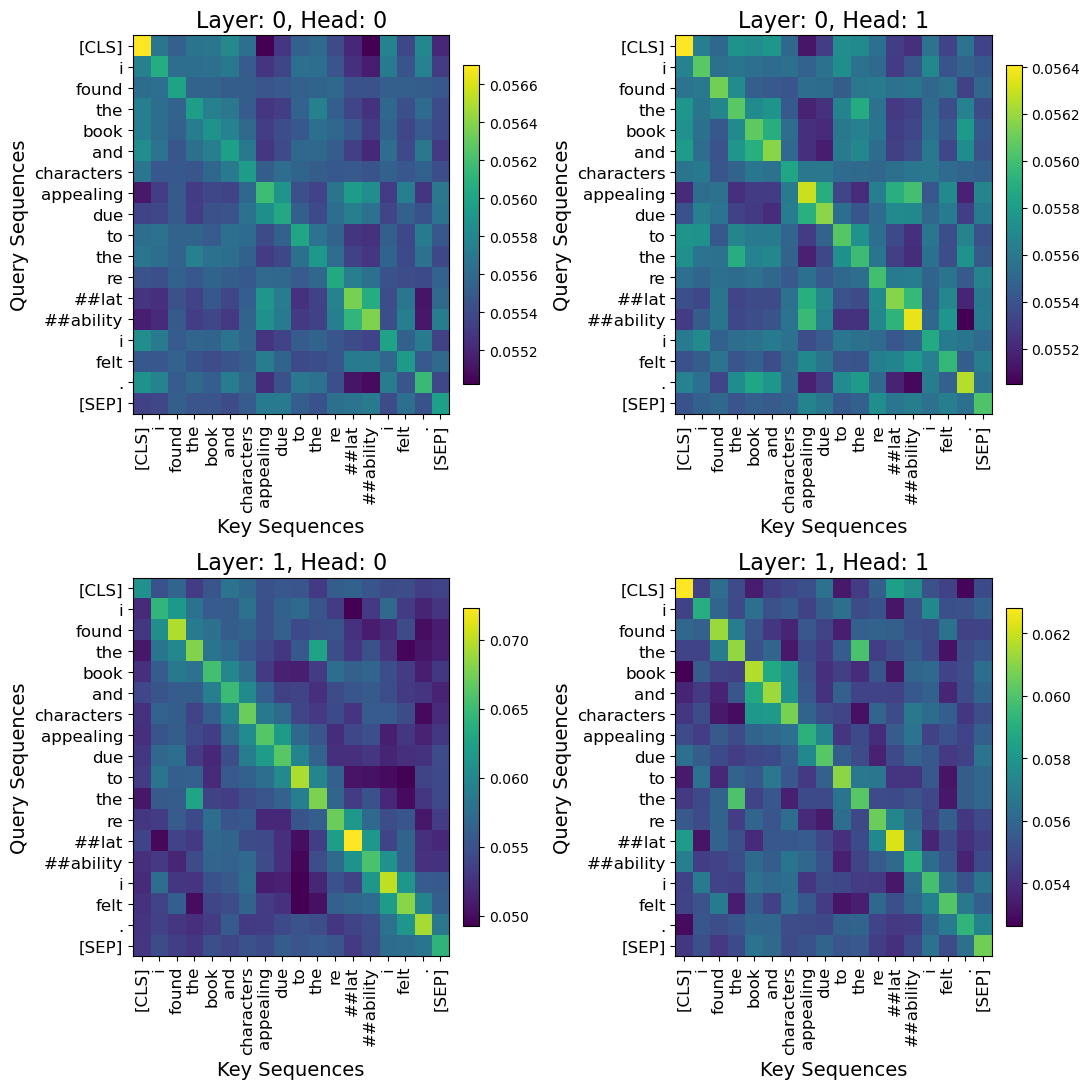

Sentence 5: I was drawn to the book and characters because they resonated with me.


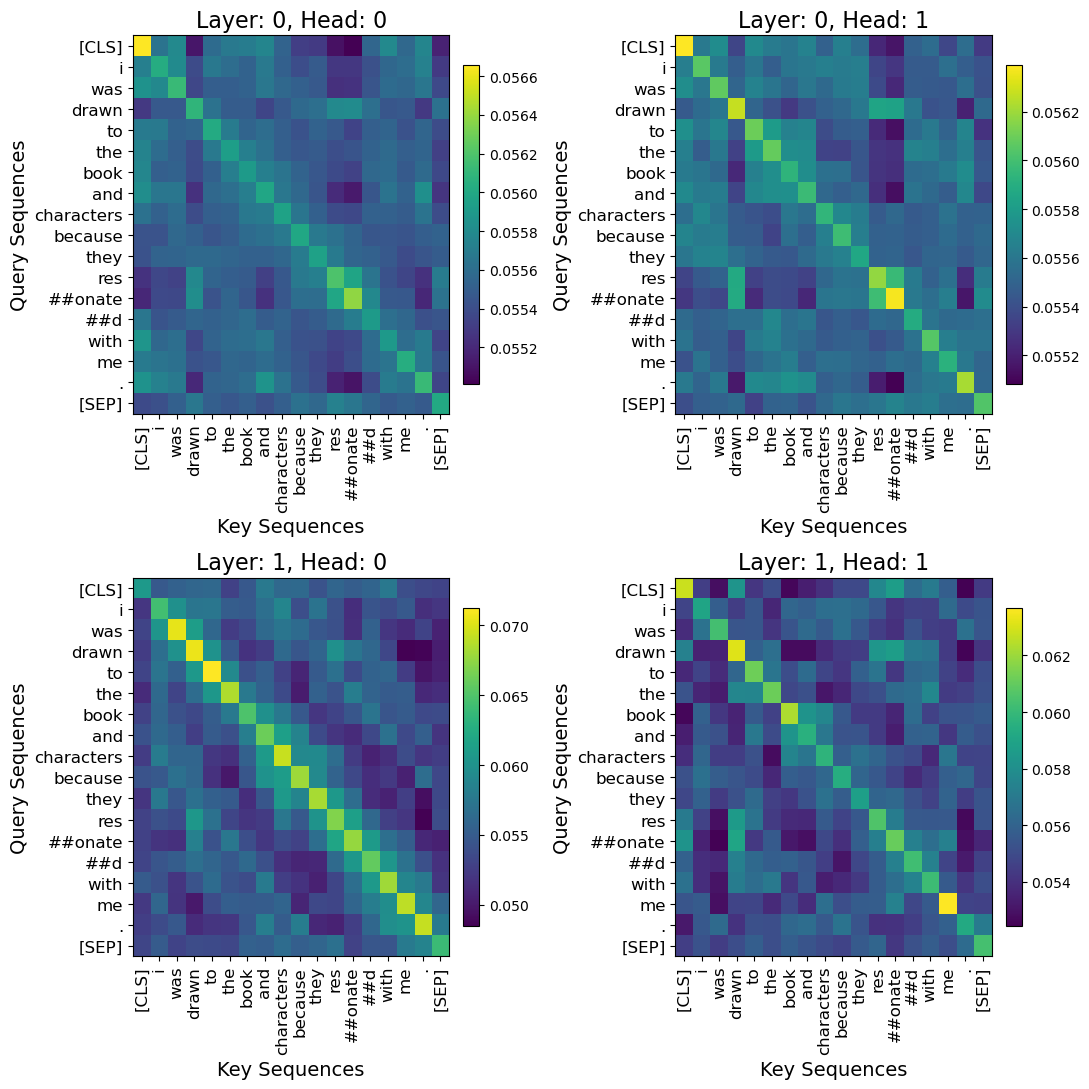

In [16]:
def attention_visualizer(sentence, model, tokenizer, layers=[-1], heads=[-1]):
    model.eval()
    with torch.no_grad():
        tokenized_input = tokenizer.encode(sentence)
        ids = tokenized_input.ids
        _, attns = model(torch.tensor([ids]).to(device))
        num_layers = len(layers)
        num_heads = len(heads)
        fig, axs = plt.subplots(num_layers, num_heads, figsize=(num_heads*5.5, num_layers*5.5))
        if num_layers == 1 and num_heads == 1:
            axs = np.array([[axs]])
        if not isinstance(axs, np.ndarray):
            axs = np.array(axs)
        if axs.ndim == 1:
            axs = np.expand_dims(axs, axis=0 if num_layers == 1 else 1)

        for i, layer in enumerate(layers):
            for j, head in enumerate(heads):
                attn = attns[layer][0, head] 
                attn_weights = attn.squeeze(0).cpu().numpy() 

                cax = axs[i, j].imshow(attn_weights, cmap='viridis', aspect='auto')
                fig.colorbar(cax, ax=axs[i, j], fraction=0.046, pad=0.04)

                tokens = tokenized_input.tokens
                axs[i, j].set_xticks(np.arange(len(tokens)))
                axs[i, j].set_yticks(np.arange(len(tokens)))
                axs[i, j].set_xticklabels(tokens, rotation=90, fontsize=12)
                axs[i, j].set_yticklabels(tokens, fontsize=12)
                axs[i, j].set_xlabel('Key Sequences', fontsize=14)
                axs[i, j].set_ylabel('Query Sequences', fontsize=14)
                axs[i, j].set_title(f'Layer: {layer}, Head: {head}', fontsize=16)

        plt.tight_layout()
        plt.show()

sentences = [
    "I enjoyed the novel and personalities since I could connect with it.",
    "I enjoyed the story and individuals as I found it relatable.",
    "I appreciated the book and its characters because I could identify with them.",
    "I found the book and characters appealing due to the relatability I felt.",
    "I was drawn to the book and characters because they resonated with me."
]

for i in range(len(sentences)):
    sentence = sentences[i]
    print(f"Sentence {i + 1}: {sentence}")
    attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1])
